<a href="https://colab.research.google.com/gist/dilithjay/5a15b87e3594b6c8eb995d12034a390f/custom-image-classification-with-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import glob
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image, ImageReadMode

# Datasets and Dataloaders

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5)
])

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.transform = transform
        self.image_paths = []
        for ext in ['png', 'jpg']:
            self.image_paths += glob.glob(os.path.join(root_dir, '*', f'*.{ext}'))
        class_set = set()
        for path in self.image_paths:
            class_set.add(os.path.basename(os.path.dirname(path)))
        self.class_lbl = { cls: i for i, cls in enumerate(sorted(list(class_set)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = read_image(self.image_paths[idx], ImageReadMode.RGB).float()
        cls = os.path.basename(os.path.dirname(self.image_paths[idx]))
        label = self.class_lbl[cls]

        return self.transform(img), torch.tensor(label), self.image_paths[idx]

In [4]:
dataset = CustomDataset('images1/', transform)

In [5]:
splits = [0.8, 0.1, 0.1]
split_sizes = []
for sp in splits[:-1]:
    split_sizes.append(int(sp * len(dataset)))
split_sizes.append(len(dataset) - sum(split_sizes))

train_set, test_set, val_set = torch.utils.data.random_split(dataset, split_sizes)

In [6]:
dataloaders = {
    "train": DataLoader(train_set, batch_size=8, shuffle=True),
    "test": DataLoader(test_set, batch_size=8, shuffle=False),
    "val": DataLoader(val_set, batch_size=8, shuffle=False)
}

# Model Definition

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [8]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(2048, 4)
model.to(device)
pass

In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training

In [10]:
EPOCHS = 20
NUM_CLASSES = len(dataset.class_lbl)

In [11]:
dataset.class_lbl

{'masked': 0, 'masked_sunglasses': 1, 'neutral': 2, 'sunglasses': 3}

In [12]:
metrics = {
    'train': {'loss': [], 'accuracy': []},
    'val': {'loss': [], 'accuracy': []},
}

In [13]:
val_acc = 0
for epoch in range(EPOCHS):
  ep_metrics = {
    'train': {'loss': 0, 'accuracy': 0, 'count': 0},
    'val': {'loss': 0, 'accuracy': 0, 'count': 0},
  }

  print(f'Epoch {epoch}')

  for phase in ['train', 'val']:
    print(f'-------- {phase} --------')
    for images, labels, _ in tqdm(dataloaders[phase]):
      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels,
                                                num_classes=NUM_CLASSES)
        loss = criterion(output, ohe_label.float().to(device))

        correct_preds = labels.to(device) == torch.argmax(output, dim=1)
        accuracy = (correct_preds).sum()/len(labels)

      if phase == 'train':
        loss.backward()
        optimizer.step()

      ep_metrics[phase]['loss'] += loss.item()
      ep_metrics[phase]['accuracy'] += accuracy.item()
      ep_metrics[phase]['count'] += 1
  
    ep_loss = ep_metrics[phase]['loss']/ep_metrics[phase]['count']
    ep_accuracy = ep_metrics[phase]['accuracy']/ep_metrics[phase]['count']

    print(f'Loss: {ep_loss}, Accuracy: {ep_accuracy}\n')

    metrics[phase]['loss'].append(ep_loss)
    metrics[phase]['accuracy'].append(ep_accuracy)
    if(phase == 'val' and ep_accuracy>val_acc):
      torch.save(model, "saved_models/best_model.pth")
      print(val_acc)
      val_acc = ep_accuracy
  torch.save(model, "saved_models/model_" + str(epoch) + ".pth")

Epoch 0
-------- train --------


  0%|          | 0/268 [00:00<?, ?it/s]c:\Users\yagya\AppData\Local\Continuum\anaconda3\envs\controlexpert\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


100%|██████████| 268/268 [01:39<00:00,  2.70it/s]


Loss: 1.261362617362791, Accuracy: 0.5555037313432836

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  7.83it/s]


Loss: 1.0701883855987997, Accuracy: 0.7757352941176471

0
Epoch 1
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.04it/s]


Loss: 0.7882133341992079, Accuracy: 0.8283582089552238

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  8.31it/s]


Loss: 0.5736357052536571, Accuracy: 0.8676470588235294

0.7757352941176471
Epoch 2
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.04it/s]


Loss: 0.4117654432167313, Accuracy: 0.9057835820895522

-------- val --------


100%|██████████| 34/34 [00:03<00:00,  8.77it/s]


Loss: 0.3714958674767438, Accuracy: 0.8970588235294118

0.8676470588235294
Epoch 3
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.04it/s]


Loss: 0.27476205583661795, Accuracy: 0.9291044776119403

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  8.45it/s]


Loss: 0.3012770065928207, Accuracy: 0.8970588235294118

Epoch 4
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.04it/s]


Loss: 0.22414299261881343, Accuracy: 0.9365671641791045

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  8.37it/s]


Loss: 0.28286271564224186, Accuracy: 0.9117647058823529

0.8970588235294118
Epoch 5
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.02it/s]


Loss: 0.18213200244579963, Accuracy: 0.9477611940298507

-------- val --------


100%|██████████| 34/34 [00:03<00:00,  8.98it/s]


Loss: 0.2586316433461273, Accuracy: 0.9191176470588235

0.9117647058823529
Epoch 6
-------- train --------


100%|██████████| 268/268 [01:29<00:00,  2.99it/s]


Loss: 0.18314215552701213, Accuracy: 0.9430970149253731

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  8.43it/s]


Loss: 0.24640311760937467, Accuracy: 0.9191176470588235

Epoch 7
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.03it/s]


Loss: 0.14206745772302817, Accuracy: 0.9603544776119403

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  8.27it/s]


Loss: 0.23334859081489198, Accuracy: 0.9264705882352942

0.9191176470588235
Epoch 8
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.02it/s]


Loss: 0.12202369088807435, Accuracy: 0.9622201492537313

-------- val --------


100%|██████████| 34/34 [00:03<00:00,  8.61it/s]


Loss: 0.23092696487027056, Accuracy: 0.9264705882352942

Epoch 9
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.03it/s]


Loss: 0.10986403185081904, Accuracy: 0.9668843283582089

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  8.40it/s]


Loss: 0.21309371788383408, Accuracy: 0.9411764705882353

0.9264705882352942
Epoch 10
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.01it/s]


Loss: 0.09467775273699758, Accuracy: 0.9734141791044776

-------- val --------


100%|██████████| 34/34 [00:03<00:00,  8.67it/s]


Loss: 0.18846813991994543, Accuracy: 0.9448529411764706

0.9411764705882353
Epoch 11
-------- train --------


100%|██████████| 268/268 [01:27<00:00,  3.05it/s]


Loss: 0.08700120411709007, Accuracy: 0.9785447761194029

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  8.49it/s]


Loss: 0.18331170603906846, Accuracy: 0.9448529411764706

Epoch 12
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.03it/s]


Loss: 0.07233919580414919, Accuracy: 0.9794776119402985

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  8.24it/s]


Loss: 0.18395489052978947, Accuracy: 0.9448529411764706

Epoch 13
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.03it/s]


Loss: 0.06052453739398312, Accuracy: 0.9855410447761194

-------- val --------


100%|██████████| 34/34 [00:04<00:00,  7.85it/s]


Loss: 0.17562036907902973, Accuracy: 0.9411764705882353

Epoch 14
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.03it/s]


Loss: 0.058027760487105416, Accuracy: 0.9836753731343284

-------- val --------


100%|██████████| 34/34 [00:03<00:00,  8.83it/s]


Loss: 0.15863778401056633, Accuracy: 0.9522058823529411

0.9448529411764706
Epoch 15
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.03it/s]


Loss: 0.03963647020977241, Accuracy: 0.9916044776119403

-------- val --------


100%|██████████| 34/34 [00:03<00:00,  8.81it/s]


Loss: 0.15734448259258094, Accuracy: 0.9485294117647058

Epoch 16
-------- train --------


100%|██████████| 268/268 [01:29<00:00,  3.00it/s]


Loss: 0.03888164639625865, Accuracy: 0.9939365671641791

-------- val --------


100%|██████████| 34/34 [00:05<00:00,  6.64it/s]


Loss: 0.14808518842191382, Accuracy: 0.9595588235294118

0.9522058823529411
Epoch 17
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.01it/s]


Loss: 0.03465791601373175, Accuracy: 0.9897388059701493

-------- val --------


100%|██████████| 34/34 [00:03<00:00,  8.50it/s]


Loss: 0.15773278953480152, Accuracy: 0.9448529411764706

Epoch 18
-------- train --------


100%|██████████| 268/268 [01:28<00:00,  3.02it/s]


Loss: 0.029794124444623465, Accuracy: 0.9925373134328358

-------- val --------


100%|██████████| 34/34 [00:02<00:00, 12.87it/s]


Loss: 0.17353298280196375, Accuracy: 0.9558823529411765

Epoch 19
-------- train --------


100%|██████████| 268/268 [01:18<00:00,  3.40it/s]


Loss: 0.026805640876800544, Accuracy: 0.9944029850746269

-------- val --------


100%|██████████| 34/34 [00:02<00:00, 12.42it/s]


Loss: 0.14331212011850714, Accuracy: 0.9705882352941176

0.9595588235294118


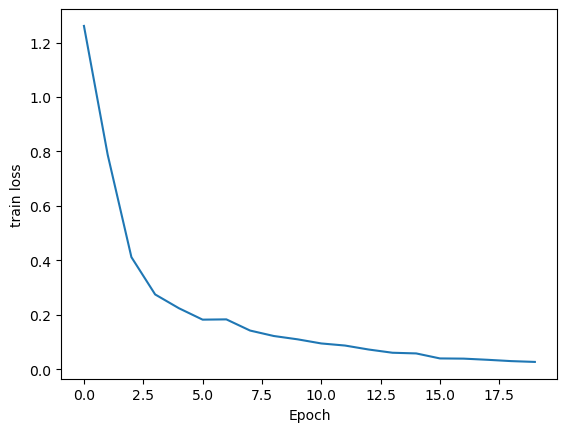

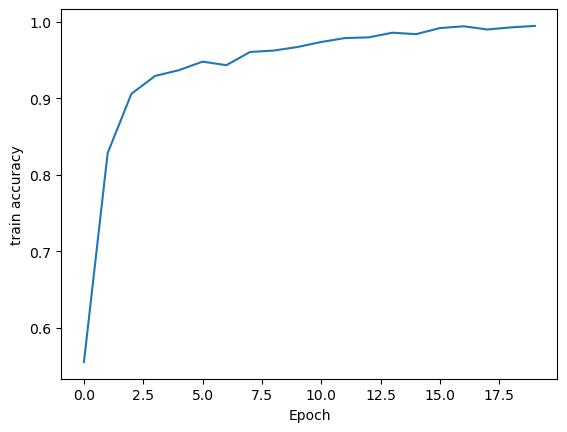

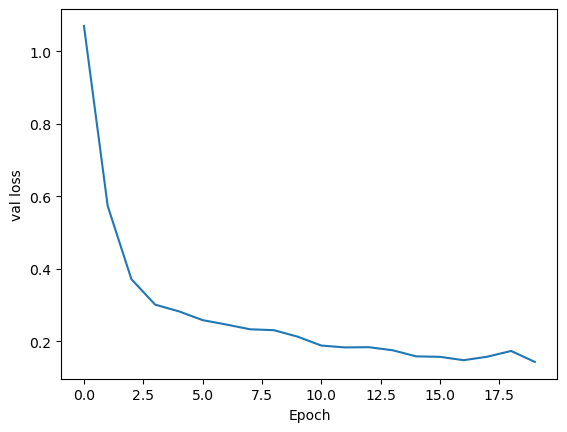

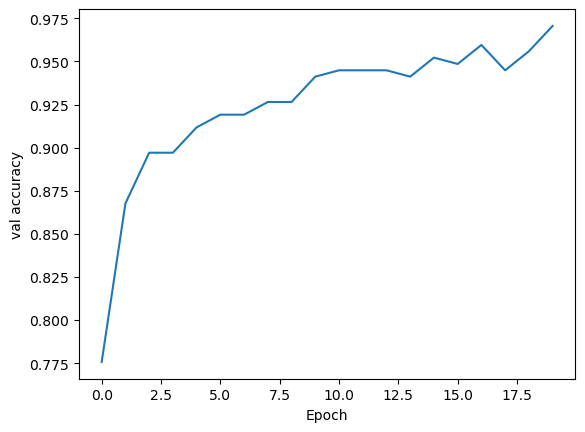

In [14]:
for phase in metrics:
    for metric in metrics[phase]:
        metric_data = metrics[phase][metric]
        plt.plot(range(len(metric_data)), metric_data)
        plt.xlabel('Epoch')
        plt.ylabel(f'{phase} {metric}')
        plt.show()

# Testing

In [15]:
model = torch.load("saved_models/best_model.pth")
preds = []
actual = []

tot_loss = tot_acc = count = 0

misclassified = []

for images, labels, img_paths in tqdm(dataloaders['test']):
    with torch.set_grad_enabled(False):
        output = model(images.to(device))
        ohe_label = torch.nn.functional.one_hot(labels, num_classes=NUM_CLASSES)
        out_labels = torch.argmax(output, dim=1)


        tot_loss += criterion(output, ohe_label.float().to(device))
        tot_acc += (labels.to(device) == out_labels).sum()/len(labels)
        mis_paths = [[img_paths[i], x.item(), y.item()] for i, (x,y) in enumerate(zip(labels, out_labels)) if x != y]
        if(len(mis_paths) > 0):
            misclassified.append(mis_paths[0])
        count += 1

    preds += out_labels.tolist()
    actual += labels.tolist()

print(f"Test Loss: {tot_loss / count}, Test Accuracy: {tot_acc / count}")

100%|██████████| 34/34 [00:02<00:00, 11.94it/s]

Test Loss: 0.18280863761901855, Test Accuracy: 0.9595588445663452


['masked', 'masked_sunglasses', 'neutral', 'sunglasses']


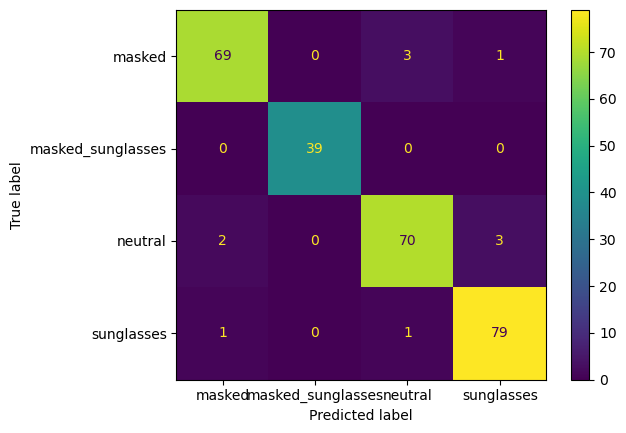

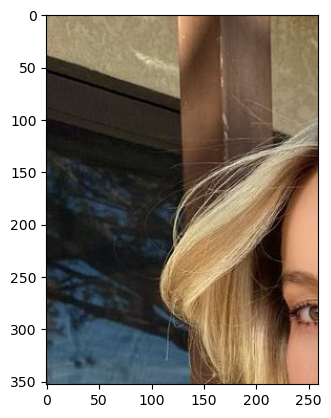

Original class: neutral  Predicted class: masked


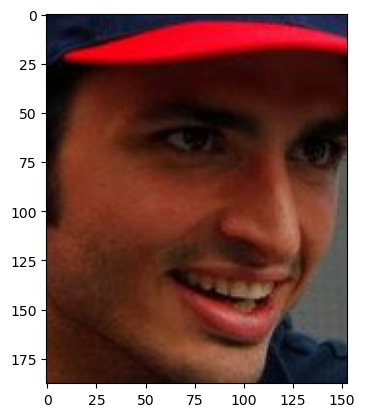

Original class: sunglasses  Predicted class: neutral


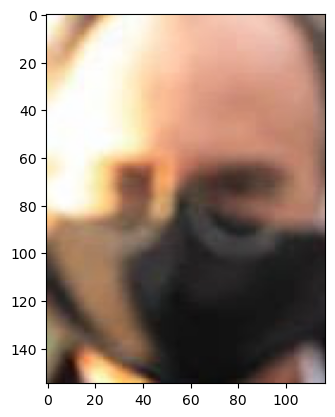

Original class: masked  Predicted class: sunglasses


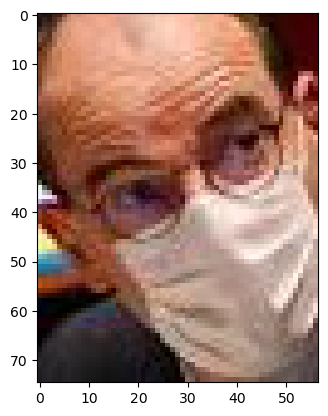

Original class: masked  Predicted class: neutral


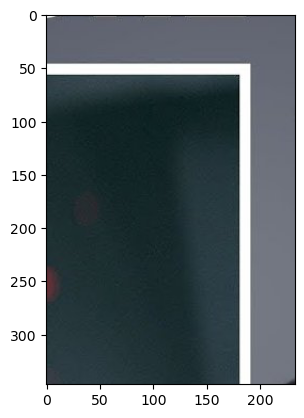

Original class: neutral  Predicted class: sunglasses


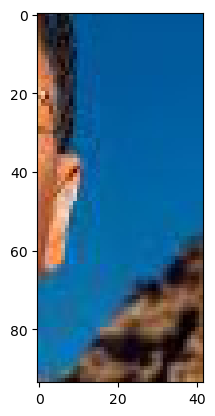

Original class: sunglasses  Predicted class: masked


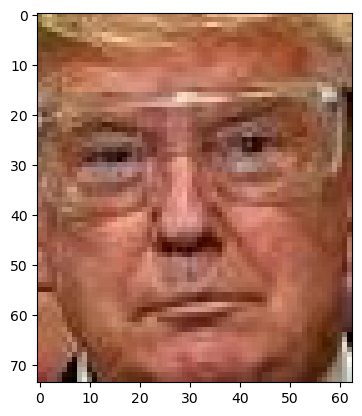

Original class: masked  Predicted class: neutral


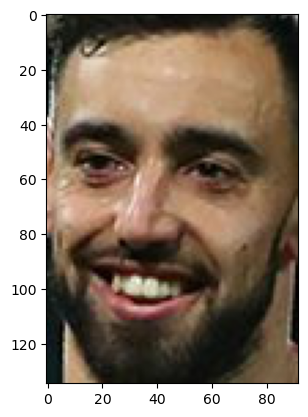

Original class: neutral  Predicted class: sunglasses


In [16]:
import shutil

class_labels = sorted(dataset.class_lbl.keys())
print(class_labels)

cm = confusion_matrix(actual, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot()
plt.show()

for i in misclassified:
    shutil.copy(i[0], "misclassified/")
    img = plt.imread(i[0])
    imgplot = plt.imshow(img)
    plt.show()
    print("Original class:", class_labels[i[1]], " Predicted class:", class_labels[i[2]])
    

In [17]:
cm_np = np.array(cm)
stats = pd.DataFrame(index=class_labels)
stats['Precision'] = [cm_np[i, i]/np.sum(cm_np[:, i]) for i in range(len(cm_np))]
stats['Recall'] = [cm_np[i, i]/np.sum(cm_np[i, :]) for i in range(len(cm_np))]

In [18]:
stats

,Precision,Recall
masked,0.958333,0.945205
masked_sunglasses,1.000000,1.000000
neutral,0.945946,0.933333
sunglasses,0.951807,0.975309


# Image Inference

In [19]:
from facenet_pytorch import MTCNN
import mmcv, cv2
from PIL import Image, ImageDraw, ImageFont
from IPython import display

mtcnn = MTCNN(keep_all=True, device=device, image_size=128)
classes = ["masked", "masked_sunglasses", "neutral", "sunglasses"]

model_infer = torch.load("saved_models/best_model.pth")

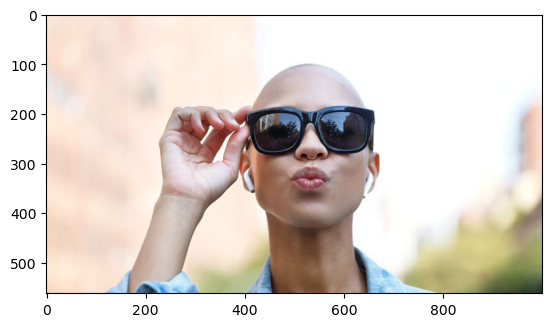

Image class:  sunglasses  Confidence:  70.3 %


In [20]:
img_infer = Image.open("../Face_detection/examples/2.jpg")
img = mtcnn(img_infer, save_path="../Face_detection/detected/masked/2.jpg")

img_dis = plt.imread("../Face_detection/examples/2.jpg")
imgplot = plt.imshow(img_dis)
plt.show()

# img_infer = img_infer[None, :, : , :]
# assert img_infer.shape == ()
result = model_infer(img.to(device))
s_result = torch.nn.functional.softmax(result, dim=1)
out_label = torch.argmax(s_result, dim=1)

out_c = s_result.cpu().detach().numpy()
out = out_label.cpu().detach().numpy()
for key, val in dataset.class_lbl.items():
    if(val == out[0]): 
        print("Image class: ", key, " Confidence: ", round(np.max(out_c*100),2) , "%")

# Video inference

Tracking frame: 146

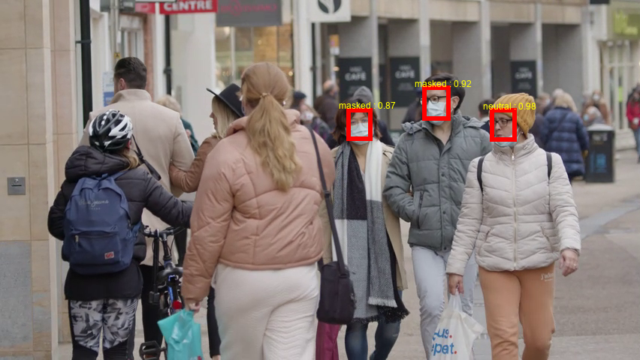

In [21]:
video = mmcv.VideoReader("../Face_detection/videos/masked.mp4")
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
frames_tracked = []
model = torch.load("saved_models/best_model.pth")
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
        
    # Detect faces
    boxes, _ = mtcnn.detect(frame)

    # Save cropped images
    img = mtcnn(frame, save_path="../Face_detection/detected/masked/" + str(i) + ".jpg")
        
    if(img is not None):
        result = model(img.to(device))
        s_result = torch.nn.functional.softmax(result, dim=1)
        out_label = torch.argmax(result, dim=1)
        out_c = s_result.cpu().detach().numpy()
        out = out_label.cpu().detach().numpy()
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    if(boxes is not None):
        for out1, out_c1, box in zip(out, out_c, boxes):
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
            draw.text((box[0]-10, box[1]-10), classes[out1] + " : " + str(round(np.max(out_c1), 2)), font=ImageFont.truetype('arial', 12), fill=(255,255,0,255))
    else:
        continue
        
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
    
d = display.display(frames_tracked[72], display_id=True)
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('../Face_detection/tracked_videos/masked_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()